In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

zip_path = "/content/drive/MyDrive/CIP/Dataset/archive.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf

DATASET_PATH = "/content/dataset/boss_256_0.4/cover"
IMAGE_SIZE = (256, 256)
MIN_SIZE_BYTES = 7 * 1024
def load_images(dataset_path, image_size, min_size_bytes):
    images = []
    valid_extensions = (".png", ".jpg", ".jpeg", ".bmp", ".tiff")
    filenames = [
        f for f in os.listdir(dataset_path)
        if f.lower().endswith(valid_extensions) and os.path.getsize(os.path.join(dataset_path, f)) > min_size_bytes
    ]

    for filename in filenames:
        img_path = os.path.join(dataset_path, filename)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Warning: Could not read {img_path}")
            continue

        img = cv2.resize(img, image_size)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=-1)
        images.append(img)

    return np.stack(images, axis=0) if images else np.array([])

cover_images = load_images(DATASET_PATH, IMAGE_SIZE, MIN_SIZE_BYTES)

print("Cover Images Shape:", cover_images.shape)
print("Min Pixel Value:", np.min(cover_images), "Max Pixel Value:", np.max(cover_images))
print(f"Total Images Loaded: {cover_images.shape[0]}")


Cover Images Shape: (6357, 256, 256, 1)
Min Pixel Value: 0.0 Max Pixel Value: 1.0
Total Images Loaded: 6357


In [ ]:
cover_images1=cover_images[:2500]
print(f"Cover Images Shape:{cover_images1.shape}")

Cover Images Shape:(2500, 256, 256, 1)


In [ ]:

!pip install Faker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.2 MB/s eta 0:00:00


In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import struct
from faker import Faker

fake = Faker()
MAX_BITS = 16384  # Ensuring each message fits within this

def generate_patient_info():
    """Generate and pack structured patient data into binary format."""
    patient_id = int(fake.random_number(digits=8))  # UUID as integer
    age = fake.random_int(min=18, max=99)
    gender = fake.random_element(elements=("M", "F", "O")).encode()  # Single character
    blood_type = fake.random_element(elements=("A+", "A-", "B+", "B-", "O+", "O-", "AB+", "AB-")).encode()

    # Convert lists to fixed-size strings (comma-separated and truncated)
    allergies = ",".join(fake.words(3))[:30].encode()
    chronic_conditions = ",".join(fake.words(5))[:50].encode()
    medications = ",".join(fake.sentences(3))[:80].encode()
    treatments = ",".join(fake.sentences(3))[:80].encode()
    visits = ",".join([fake.date_this_decade().isoformat() for _ in range(3)])[:50].encode()

    # Lab results (fixed-size)
    hemoglobin = round(fake.pyfloat(min_value=10.0, max_value=18.0, right_digits=1), 1)
    cholesterol = round(fake.pyfloat(min_value=100.0, max_value=250.0, right_digits=1), 1)
    systolic_bp = fake.random_int(90, 140)
    diastolic_bp = fake.random_int(60, 90)
    heart_rate = fake.random_int(60, 100)

    # Pack all fields into binary format (Big-endian for consistency)
    binary_data = struct.pack(
        ">I B c 2s 30s 50s 80s 80s 50s f f H H H",
        patient_id, age, gender, blood_type,
        allergies, chronic_conditions, medications, treatments, visits,
        hemoglobin, cholesterol, systolic_bp, diastolic_bp, heart_rate
    )

    # Convert binary data to a bit array
    bit_array = np.unpackbits(np.frombuffer(binary_data, dtype=np.uint8))

    # Pad or truncate to MAX_BITS
    return np.pad(bit_array, (0, max(0, MAX_BITS - len(bit_array))), 'constant')

# Example usage
num_images = len(cover_images1)  # Adjust based on your dataset
binary_messages = [generate_patient_info() for _ in range(num_images)]

# Convert to fixed-shape NumPy array
binary_messages = np.array(binary_messages, dtype=np.uint8)

print(f"✅ Created {len(binary_messages)} messages, each {len(binary_messages[0])} bits long.")
print(binary_messages.shape)


✅ Created 2500 messages, each 16384 bits long.
(2500, 16384)


In [ ]:
def create_dataset(images, messages, batch_size):
    messages = messages.astype(np.float32)
    dataset = tf.data.Dataset.from_tensor_slices((images, messages))
    dataset = dataset.shuffle(len(images)).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset

BATCH_SIZE = 32

dataset = create_dataset(cover_images1, binary_messages, BATCH_SIZE)

for batch_cover, batch_message in dataset.take(1):
    print("Cover Image Batch Shape:", batch_cover.shape)
    print("Message Batch Shape:", batch_message.shape)


Cover Image Batch Shape: (32, 256, 256, 1)
Message Batch Shape: (32, 16384)


In [ ]:
import tensorflow as tf

def generator_mse_loss_fn(cover_image, stego_image):
    mse = tf.keras.losses.MeanSquaredError()
    return mse(cover_image, stego_image)

def generator_bce_loss_fn(fake_output):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    return bce(tf.ones_like(fake_output), fake_output)

def ber_loss_fn(original_message, extracted_message):
    original_message = tf.cast(original_message, tf.float32)
    return tf.reduce_mean(tf.abs(original_message - extracted_message))

def generator_combined_loss_fn(cover_image, stego_image, fake_output, original_message, extracted_message,
                               mse_weight=1.0, bce_weight=0.2, ber_weight=0.5):
    mse_loss = generator_mse_loss_fn(cover_image, stego_image)
    bce_loss = generator_bce_loss_fn(fake_output)
    ber_loss = ber_loss_fn(original_message, extracted_message)

    return (mse_weight * mse_loss) + (bce_weight * bce_loss) + (ber_weight * ber_loss)

def discriminator_loss_fn(real_output, fake_output):

    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)

    return real_loss + fake_loss

def extractor_loss_fn(original_message, extracted_message):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    return bce(original_message, extracted_message)


In [ ]:
strategy = tf.distribute.get_strategy()

In [ ]:

from tensorflow.keras.models import load_model
with strategy.scope():
    generator = load_model("/content/drive/MyDrive/CIP/Saved_Models/new/generator_model_updated_new.keras")
    discriminator = load_model("/content/drive/MyDrive/CIP/Saved_Models/new/discriminator_model_updated_new.keras")
    extractor = load_model("/content/drive/MyDrive/CIP/Saved_Models/new2/extractor_model_updated_new.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 34 variables whereas the saved optimizer has 66 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 32 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import tensorflow as tf
import numpy as np

total_gen_loss, total_disc_acc, total_msg_acc, total_ber_loss = 0, 0, 0, 0
num_batches = 0

# Use the same dataset as corrected code
dataset = tf.data.Dataset.from_tensor_slices((cover_images1, binary_messages)).batch(32)

for batch_cover, batch_message in dataset:
    stego_images = generator([batch_cover, batch_message])
    real_output = discriminator(batch_cover)
    fake_output = discriminator(stego_images)
    extracted_messages = extractor(stego_images)

    gen_loss = tf.keras.losses.MeanSquaredError()(batch_cover, stego_images).numpy()
    real_acc = np.mean((real_output.numpy() > 0.5).astype(int) == 1)
    fake_acc = np.mean((fake_output.numpy() < 0.5).astype(int) == 1)
    disc_acc = (real_acc + fake_acc) / 2
    msg_acc = np.mean((tf.round(batch_message).numpy().astype(np.uint8) == tf.round(extracted_messages).numpy().astype(np.uint8)).astype(np.float32))
    ber_loss = ber_loss_fn(batch_message, extracted_messages).numpy()

    total_gen_loss += gen_loss
    total_disc_acc += disc_acc
    total_msg_acc += msg_acc
    total_ber_loss += ber_loss
    num_batches += 1

avg_gen_loss = total_gen_loss / num_batches
avg_disc_acc = total_disc_acc / num_batches
avg_msg_acc = total_msg_acc / num_batches
avg_ber_loss = total_ber_loss / num_batches

print("\n Model Evaluation Results")
print(f"Generator Loss: {avg_gen_loss:.6f}")
print(f"Discriminator Accuracy: {avg_disc_acc:.4f}")
print(f"Message Retrieval Accuracy: {avg_msg_acc:.4f}")
print(f"BER Loss: {avg_ber_loss:.6f}")


 Model Evaluation Results
Generator Loss: 0.002678
Discriminator Accuracy: 0.4949
Message Retrieval Accuracy: 0.9681
BER Loss: 0.040039


In [ ]:
import tensorflow as tf
import numpy as np

def evaluate_model(generator, discriminator, extractor, dataset, generator_combined_loss_fn, ber_loss_fn,
                   mse_weight=1.0, bce_weight=0.2, ber_weight=0.5, batch_size=32):
    total_gen_loss, total_disc_acc, total_msg_acc, total_ber_loss = 0.0, 0.0, 0.0, 0.0
    num_batches = 0
    dataset = dataset.batch(batch_size, drop_remainder=True)

    for batch_idx, (batch_cover, batch_message) in enumerate(dataset):
        batch_cover = tf.cast(batch_cover, tf.float32)
        batch_message = tf.cast(batch_message, tf.float32)

        stego_images = generator([batch_cover, batch_message], training=False)
        real_output = discriminator(batch_cover, training=False)
        fake_output = discriminator(stego_images, training=False)
        extracted_messages = extractor(stego_images, training=False)

        gen_loss = generator_combined_loss_fn(
            cover_image=batch_cover, stego_image=stego_images, fake_output=fake_output,
            original_message=batch_message, extracted_message=extracted_messages,
            mse_weight=mse_weight, bce_weight=bce_weight, ber_weight=ber_weight
        )
        real_acc = tf.reduce_mean(tf.cast(real_output > 0.5, tf.float32))
        fake_acc = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
        disc_acc = (real_acc + fake_acc) / 2
        msg_acc = tf.reduce_mean(tf.cast(tf.equal(tf.round(batch_message), tf.round(extracted_messages)), tf.float32))
        ber_loss = ber_loss_fn(batch_message, extracted_messages)

        total_gen_loss += gen_loss.numpy()
        total_disc_acc += disc_acc.numpy()
        total_msg_acc += msg_acc.numpy()
        total_ber_loss += ber_loss.numpy()
        num_batches += 1
        print(f"Batch {batch_idx+1}: Disc Acc: {disc_acc.numpy():.4f}, Msg Acc: {msg_acc.numpy():.4f}, BER: {ber_loss.numpy():.6f}")
        # print(f"Batch {batch_idx + 1}: Msg Acc: {msg_acc.numpy():.4f}, BER: {ber_loss.numpy():.6f}")

    avg_gen_loss = total_gen_loss / num_batches
    avg_disc_acc = total_disc_acc / num_batches
    avg_msg_acc = total_msg_acc / num_batches
    avg_ber_loss = total_ber_loss / num_batches

    print("\nCorrected Model Evaluation Results:")
    print(f"Generator Loss: {avg_gen_loss:.6f}")
    print(f"Discriminator Accuracy: {avg_disc_acc:.4f}")
    print(f"Message Retrieval Accuracy: {avg_msg_acc:.4f}")
    print(f"BER Loss: {avg_ber_loss:.6f}")

    return avg_gen_loss, avg_disc_acc, avg_msg_acc, avg_ber_loss

# Run evaluation
dataset = tf.data.Dataset.from_tensor_slices((cover_images1, binary_messages)).shuffle(buffer_size=len(cover_images1))
avg_gen_loss, avg_disc_acc, avg_msg_acc, avg_ber_loss = evaluate_model(
    generator=generator,
    discriminator=discriminator,
    extractor=extractor,
    dataset=dataset,
    generator_combined_loss_fn=generator_combined_loss_fn,
    ber_loss_fn=ber_loss_fn,
    mse_weight=1.0,
    bce_weight=0.2,
    ber_weight=0.5,
    batch_size=32
)

# Test index 500


Batch 1: Disc Acc: 0.4062, Msg Acc: 0.9681, BER: 0.039956
Batch 2: Disc Acc: 0.4219, Msg Acc: 0.9678, BER: 0.040189
Batch 3: Disc Acc: 0.4062, Msg Acc: 0.9679, BER: 0.040163
Batch 4: Disc Acc: 0.4062, Msg Acc: 0.9682, BER: 0.039968
Batch 5: Disc Acc: 0.4375, Msg Acc: 0.9682, BER: 0.039894
Batch 6: Disc Acc: 0.4531, Msg Acc: 0.9681, BER: 0.039937
Batch 7: Disc Acc: 0.3750, Msg Acc: 0.9675, BER: 0.040368
Batch 8: Disc Acc: 0.3906, Msg Acc: 0.9684, BER: 0.039739
Batch 9: Disc Acc: 0.3750, Msg Acc: 0.9683, BER: 0.039792
Batch 10: Disc Acc: 0.3281, Msg Acc: 0.9683, BER: 0.039952
Batch 11: Disc Acc: 0.3906, Msg Acc: 0.9678, BER: 0.040036
Batch 12: Disc Acc: 0.3750, Msg Acc: 0.9680, BER: 0.040112
Batch 13: Disc Acc: 0.3750, Msg Acc: 0.9677, BER: 0.040215
Batch 14: Disc Acc: 0.4219, Msg Acc: 0.9682, BER: 0.040001
Batch 15: Disc Acc: 0.4375, Msg Acc: 0.9681, BER: 0.039985
Batch 16: Disc Acc: 0.4219, Msg Acc: 0.9682, BER: 0.039927
Batch 17: Disc Acc: 0.4375, Msg Acc: 0.9680, BER: 0.040123
Batch 

In [ ]:
index = 500
cover_image = tf.expand_dims(cover_images1[index], 0)
message = tf.expand_dims(binary_messages[index], 0)
stego_image = generator([cover_image, message], training=False)
extracted_message = extractor(stego_image, training=False)
bit_errors = tf.reduce_sum(tf.cast(tf.not_equal(tf.cast(tf.round(message), tf.uint8), tf.cast(tf.round(extracted_message), tf.uint8)), tf.float32))
ber = bit_errors / tf.size(message, out_type=tf.float32)
msg_acc = tf.reduce_mean(tf.cast(tf.equal(tf.cast(tf.round(message), tf.uint8), tf.cast(tf.round(extracted_message), tf.uint8)), tf.float32))
# msg_acc = np.mean((tf.round(batch_message).numpy().astype(np.uint8) == tf.round(extracted_messages).numpy().astype(np.uint8)).astype(np.float32))
print(f"\nIndex 500: Msg Acc: {msg_acc.numpy():.4f}, BER: {ber.numpy():.6f}, Bit Errors: {bit_errors.numpy()}")


Index 500: Msg Acc: 0.9678, BER: 0.032227, Bit Errors: 528.0


In [ ]:
import tensorflow as tf
import numpy as np

total_gen_loss, total_disc_acc, total_msg_acc, total_ber_loss = 0, 0, 0, 0
num_batches = 0

for batch_cover, batch_message in dataset:

    stego_images = generator([batch_cover,batch_message])

    real_output = discriminator(batch_cover)
    fake_output = discriminator(stego_images)

    extracted_messages = extractor(stego_images)

    gen_loss = tf.keras.losses.MeanSquaredError()(batch_cover, stego_images).numpy()

    real_acc = np.mean((real_output.numpy() > 0.5).astype(int) == 1)
    fake_acc = np.mean((fake_output.numpy() < 0.5).astype(int) == 1)
    disc_acc = (real_acc + fake_acc) / 2

    msg_acc = np.mean((tf.round(batch_message) == tf.round(extracted_messages)).numpy().astype(np.float32))
    ber_loss = ber_loss_fn(batch_message, extracted_messages).numpy()

    total_gen_loss += gen_loss
    total_disc_acc += disc_acc
    total_msg_acc += msg_acc
    total_ber_loss += ber_loss
    num_batches += 1

avg_gen_loss = total_gen_loss / num_batches
avg_disc_acc = total_disc_acc / num_batches
avg_msg_acc = total_msg_acc / num_batches
avg_ber_loss = total_ber_loss / num_batches

print("\nModel Evaluation Results")
print(f"Generator Loss: {avg_gen_loss:.6f}")
print(f" Discriminator Accuracy: {avg_disc_acc:.4f}")
print(f" Message Retrieval Accuracy: {avg_msg_acc:.4f}")
print(f" BER Loss: {avg_ber_loss:.6f}")


Model Evaluation Results
Generator Loss: 0.002070
 Discriminator Accuracy: 0.8433
 Message Retrieval Accuracy: 0.9681
 BER Loss: 0.040013


In [ ]:
def generate_stego_image(generator, cover_image, message):
    cover_image = np.expand_dims(cover_image, axis=0)  # Add batch dimension
    message = message.reshape(1, -1)   # Add batch dimension

    stego_image = generator.predict([cover_image, message])
    stego_image = np.squeeze(stego_image, axis=0)  # Remove batch dimension

    return stego_image

def decode_patient_info(binary_message):
    """Decode binary bit array back to structured patient info."""
    byte_array = np.packbits(binary_message)  # Convert bits to bytes
    buffer_size = struct.calcsize(">I B c 2s 30s 50s 80s 80s 50s f f H H H")
    unpacked_data = struct.unpack(">I B c 2s 30s 50s 80s 80s 50s f f H H H", byte_array[:buffer_size])

    # Convert back to readable format
    patient_info = {
        "patient_id": unpacked_data[0],
        "age": unpacked_data[1],
        "gender": unpacked_data[2].decode(),
        "blood_type": unpacked_data[3].decode(),
        "allergies": unpacked_data[4].decode().strip(),
        "chronic_conditions": unpacked_data[5].decode().strip(),
        "current_medications": unpacked_data[6].decode().strip(),
        "recent_treatments": unpacked_data[7].decode().strip(),
        "hospital_visits": unpacked_data[8].decode().strip(),
        "lab_results": {
            "hemoglobin": unpacked_data[9],
            "cholesterol": unpacked_data[10],
            "blood_pressure": f"{unpacked_data[11]}/{unpacked_data[12]}",
            "heart_rate": unpacked_data[13]
        }
    }

    return patient_info

def extract_message(stego_image):
    stego_image = np.expand_dims(stego_image, axis=0)
    extracted_message = extractor.predict(stego_image)
    extracted_message = np.round(extracted_message).astype(np.uint8)
    return extracted_message.squeeze()
def count_bit_errors(original,extracted):
    original = original.flatten()
    extracted = extracted.flatten()
    bit_errors = np.sum(original != extracted)
    return bit_errors

stego_image = generate_stego_image(generator, cover_images[500], binary_messages[500])
extracted_message = extract_message(stego_image)
patient_info = decode_patient_info(extracted_message)
print(patient_info)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
raw_ber = count_bit_errors(binary_messages[0], extracted_message)
print(f"BER: {raw_ber}")



BER: 537


In [ ]:
random_indices = np.random.choice(len(cover_images), 2000, replace=False)
selected_covers = cover_images[random_indices]
print(f"selected_covers:{selected_covers.shape}")
rand_indices= np.random.choice(len(binary_messages),2000,replace= False)
selected_messages=binary_messages[rand_indices]
stego_images = generator.predict([selected_covers, selected_messages])
stego_images = np.clip(stego_images, 0.0, 1.0)
# np.save("/content/drive/MyDrive/testing/attacker/stego_images_200.npy", stego_images)
# print(" Generated and saved 300 stego images.")

selected_covers:(2000, 256, 256, 1)
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step


In [ ]:
stego_images=generator.predict([cover_images,binary_messages])

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


In [ ]:
print(f"stego image shape:{stego_images.shape}")
print(f"cover image shape:{cover_images.shape}")

stego image shape:(2500, 256, 256, 1)
cover image shape:(2500, 256, 256, 1)


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# If shape is (N, H, W), expand dims to (N, H, W, 1)
if len(cover_images.shape) == 3:
    cover_images = np.expand_dims(cover_images, axis=-1)
if len(stego_images.shape) == 3:
    stego_images = np.expand_dims(stego_images, axis=-1)

# Normalize to [0, 1]
cover_images = cover_images.astype(np.float32) / 255.0
stego_images = stego_images.astype(np.float32) / 255.0

# Create labels
cover_labels = np.zeros(len(cover_images))
stego_labels = np.ones(len(stego_images))

# Merge
X = np.concatenate([cover_images, stego_images], axis=0)
y = np.concatenate([cover_labels, stego_labels], axis=0)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
# Create tf.data.Dataset
def make_dataset(images, labels, shuffle=True, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(X_train, y_train)
val_ds = make_dataset(X_val, y_val, shuffle=False)
for images, labels in train_ds.take(1):
    print(f"train_ds batch shape: {images.shape}, labels shape: {labels.shape}")
for images, labels in val_ds.take(1):
    print(f"val_ds batch shape: {images.shape}, labels shape: {labels.shape}")

X_train shape: (4000, 256, 256, 1), y_train shape: (4000,)
X_val shape: (1000, 256, 256, 1), y_val shape: (1000,)
train_ds batch shape: (32, 256, 256, 1), labels shape: (32,)
val_ds batch shape: (32, 256, 256, 1), labels shape: (32,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Flatten, Dense, MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
def build_steganalysis_network(input_shape=(256, 256, 1)):

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))  # Reduce spatial dimensions

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))  # Reduce spatial dimensions

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))  # Reduce spatial dimensions

    model.add(Flatten())
    model.add(Dense(128, kernel_regularizer=regularizers.l2(1e-3)))  # L2 regularization
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation="sigmoid"))
    return model

In [ ]:
model=build_steganalysis_network()
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,871,553 (64.36 MB)

 Trainable params: 16,870,849 (64.36 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7724 - loss: 0.7567
Epoch 1: val_loss improved from inf to 0.97779, saving model to /content/drive/MyDrive/testing/attacker/best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.7733 - loss: 0.7550 - val_accuracy: 0.5000 - val_loss: 0.9778 - learning_rate: 1.0000e-04
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9913 - loss: 0.2841
Epoch 2: val_loss did not improve from 0.97779
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.9913 - loss: 0.2840 - val_accuracy: 0.5000 - val_loss: 0.9850 - learning_rate: 1.0000e-04
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9986 - loss: 0.2350
Epoch 3: val_loss did not improve from 0.97779
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9986 - loss: 0.2350 - val_accuracy: 0.5000 - val_loss: 1.0118 - learning_rate: 1.0000e-04
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9983 - loss: 0.2

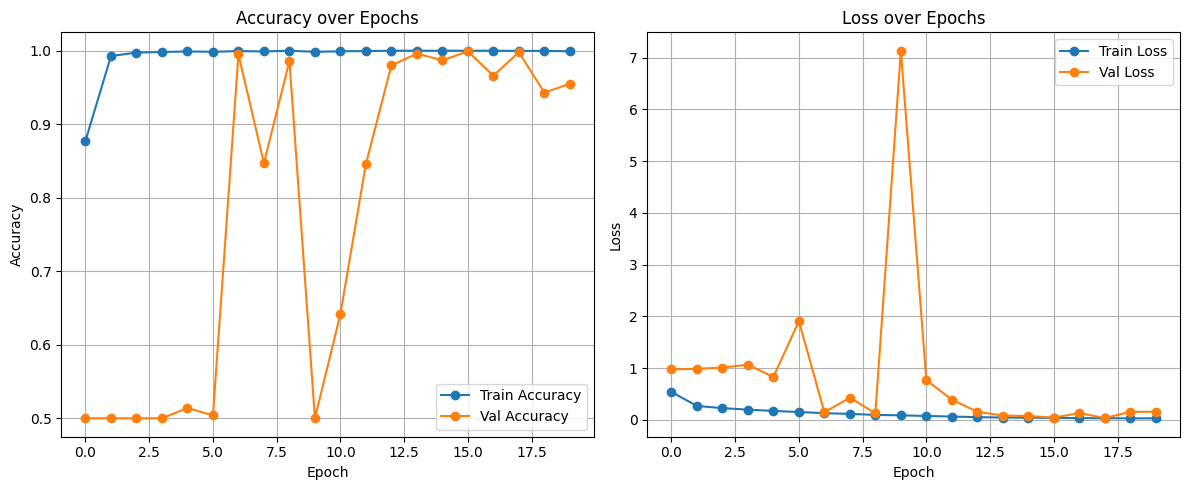

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# === Callbacks ===
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    # Optional: Save best model automatically during training
    ModelCheckpoint(
        filepath="/content/drive/MyDrive/testing/attacker/best_model.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

# === Training ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

# === Save Final Model ===
model.save("/content/drive/MyDrive/testing/attacker/grayscale_steganalysis_model.keras")

# === Plot Accuracy and Loss ===
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(history)


In [ ]:
model= load_model("/content/drive/MyDrive/testing/attacker/grayscale_steganalysis_model.h5")
def stego_or_real(image):
  image=image.astype(np.float32)/255.0
  prediction=model.predict(image)
  predicted_class = np.argmax(prediction, axis=1)[0]
  return "Cover" if predicted_class == 0 else "Stego"

test_image=generator.predict([cover_images[600:601],binary_messages[600:601]])
result = stego_or_real(test_image)
print("Prediction:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: Cover


In [ ]:
import numpy as np
import struct
from faker import Faker
from reedsolo import RSCodec
import tensorflow as tf

fake = Faker()
MAX_BITS = 16384  # Total bits available for embedding

# Initialize Reed-Solomon codec
# Let's assume we want to correct up to 100 byte errors (800 bit errors)
RS_SYMBOL_SIZE = 8  # 8 bits per symbol (byte)
RS_ECC_SYMBOLS = 200  # Corrects up to 100 byte errors
rs = RSCodec(RS_ECC_SYMBOLS, nsize=255)  # n = 255 bytes per codeword

def generate_patient_info():
    """Generate and pack structured patient data into binary format."""
    patient_id = int(fake.random_number(digits=8))
    age = fake.random_int(min=18, max=99)
    gender = fake.random_element(elements=("M", "F", "O")).encode()
    blood_type = fake.random_element(elements=("A+", "A-", "B+", "B-", "O+", "O-", "AB+", "AB-")).encode()
    allergies = ",".join(fake.words(3))[:30].encode()
    chronic_conditions = ",".join(fake.words(5))[:50].encode()
    medications = ",".join(fake.sentences(3))[:80].encode()
    treatments = ",".join(fake.sentences(3))[:80].encode()
    visits = ",".join([fake.date_this_decade().isoformat() for _ in range(3)])[:50].encode()
    hemoglobin = round(fake.pyfloat(min_value=10.0, max_value=18.0, right_digits=1), 1)
    cholesterol = round(fake.pyfloat(min_value=100.0, max_value=250.0, right_digits=1), 1)
    systolic_bp = fake.random_int(90, 140)
    diastolic_bp = fake.random_int(60, 90)
    heart_rate = fake.random_int(60, 100)

    # Pack data
    binary_data = struct.pack(
        ">I B c 2s 30s 50s 80s 80s 50s f f H H H",
        patient_id, age, gender, blood_type,
        allergies, chronic_conditions, medications, treatments, visits,
        hemoglobin, cholesterol, systolic_bp, diastolic_bp, heart_rate
    )

    return binary_data

def encode_message(binary_data):
    """Encode binary data with Reed-Solomon ECC."""
    # Calculate available message size after ECC overhead
    max_bytes = MAX_BITS // 8  # 16384 bits = 2048 bytes
    ecc_bytes = RS_ECC_SYMBOLS  # 200 bytes for ECC
    max_message_bytes = max_bytes - ecc_bytes  # 2048 - 200 = 1848 bytes
    # Reduce the message size if it exceeds the maximum allowed size
    binary_data = binary_data[:max_message_bytes]

    # Ensure binary_data fits within max_message_bytes
    if len(binary_data) > max_message_bytes:
        raise ValueError(f"Message too large: {len(binary_data)} bytes exceeds {max_message_bytes} bytes")

    # Pad binary_data to max_message_bytes if needed
    binary_data = binary_data.ljust(max_message_bytes, b"\0")

    # Apply Reed-Solomon encoding
    encoded_data = rs.encode(binary_data)

    # Convert to bit array
    bit_array = np.unpackbits(np.frombuffer(encoded_data, dtype=np.uint8))

    # Ensure bit array fits MAX_BITS
    if len(bit_array) > MAX_BITS:
        bit_array = bit_array[:MAX_BITS]
    elif len(bit_array) < MAX_BITS:
        bit_array = np.pad(bit_array, (0, MAX_BITS - len(bit_array)), "constant")

    return bit_array

def decode_message(bit_array):
    """Decode bit array with Reed-Solomon ECC to recover original message."""
    # Convert bit array to bytes
    byte_array = np.packbits(bit_array)

    # Decode with Reed-Solomon
    try:
        decoded_data = rs.decode(byte_array[:2048])[0]  # Get only the message part
    except Exception as e:
        print(f"Reed-Solomon decoding failed: {e}")
        return None

    return decoded_data

def decode_patient_info(binary_data):
    """Decode binary data back to structured patient info."""
    if binary_data is None:
        return None
    try:
        buffer_size = struct.calcsize(">I B c 2s 30s 50s 80s 80s 50s f f H H H")
        unpacked_data = struct.unpack(">I B c 2s 30s 50s 80s 80s 50s f f H H H", binary_data[:buffer_size])
        patient_info = {
            "patient_id": unpacked_data[0],
            "age": unpacked_data[1],
            "gender": unpacked_data[2].decode(),
            "blood_type": unpacked_data[3].decode(),
            "allergies": unpacked_data[4].decode().strip(),
            "chronic_conditions": unpacked_data[5].decode().strip(),
            "current_medications": unpacked_data[6].decode().strip(),
            "recent_treatments": unpacked_data[7].decode().strip(),
            "hospital_visits": unpacked_data[8].decode().strip(),
            "lab_results": {
                "hemoglobin": unpacked_data[9],
                "cholesterol": unpacked_data[10],
                "blood_pressure": f"{unpacked_data[11]}/{unpacked_data[12]}",
                "heart_rate": unpacked_data[13]
            }
        }
        return patient_info
    except Exception as e:
        print(f"Error unpacking patient info: {e}")
        return None

In [ ]:
num_images = len(cover_images1)  # e.g., 2500
binary_messages = []
for _ in range(num_images):
    binary_data = generate_patient_info()
    encoded_bits = encode_message(binary_data)
    binary_messages.append(encoded_bits)

binary_messages = np.array(binary_messages, dtype=np.uint8)
print(f"✅ Created {len(binary_messages)} messages, each {len(binary_messages[0])} bits long.")
print(binary_messages.shape)

✅ Created 2500 messages, each 16384 bits long.
(2500, 16384)


In [ ]:
def full_pipeline_test(generator, extractor, input_image):
    # Step 1: Generate binary message
    patient_binary = generate_patient_info()

    # Step 2: RS encode
    encoded_bits = encode_message(patient_binary)

    # Step 3: Convert to tensor (if needed for your generator)
    encoded_tensor = tf.convert_to_tensor(encoded_bits.reshape(1, -1), dtype=tf.float32)

    # Step 4: Generate stego image using the generator
    input_image_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
    input_image_tensor = tf.expand_dims(input_image_tensor, axis=0)  # shape (1, H, W, C)
    stego_image = generator([input_image_tensor, encoded_tensor], training=False)

    # Step 5: Extract message using the extractor
    extracted_bits = extractor(stego_image, training=False)
    bit_errors = np.sum(np.abs(encoded_bits - extracted_bits))
    print(f"🔎 Bit errors: {bit_errors} / {MAX_BITS}")
    extracted_bits = tf.squeeze(extracted_bits).numpy()

    extracted_bits = np.round(extracted_bits).astype(np.uint8)  # binarize output


    # Step 6: Decode using Reed-Solomon
    decoded_binary = decode_message(extracted_bits)
    decoded_info = decode_patient_info(decoded_binary)

    # Step 7: Compare results
    if decoded_binary and decoded_binary[:len(patient_binary)] == patient_binary:
        print("✅ Message recovered successfully!")
    else:
        print("❌ Message recovery failed or partially decoded.")
        print("📋 Decoded info (if any):", decoded_info)

full_pipeline_test(generator,extractor,cover_images1[2000])

🔎 Bit errors: 5708.0947265625 / 16384
Reed-Solomon decoding failed: Too many (or few) errors found by Chien Search for the errata locator polynomial!
❌ Message recovery failed or partially decoded.
📋 Decoded info (if any): None


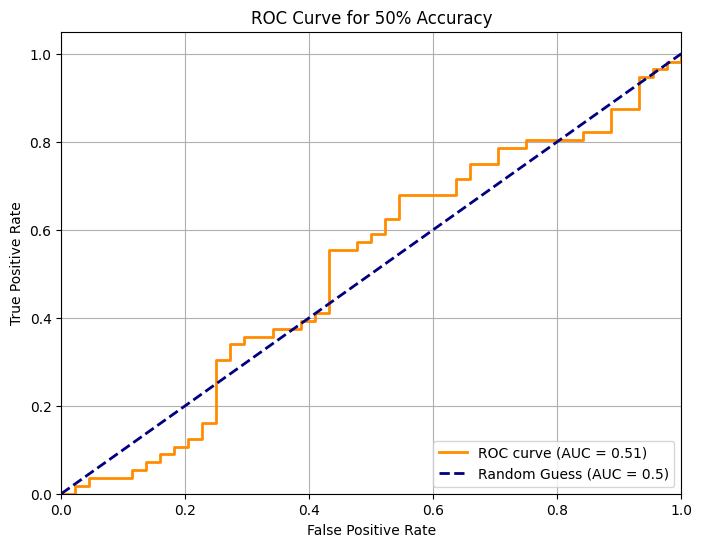

Approximate AUC: 0.51


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Simulate data for a random classifier (50% accuracy)
np.random.seed(42)
n_samples = 100

# True labels: 0 for cover images, 1 for stego images (random split)
true_labels = np.random.randint(0, 2, n_samples)

# Predicted probabilities: random values between 0 and 1 (no discriminative power)
predicted_probs = np.random.rand(n_samples)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for 50% Accuracy')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Approximate AUC: {roc_auc:.2f}")

In [ ]:
%%writefile content/drive/MyDrive/CIP/app.py
import pandas as pd
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf
import struct
from faker import Faker
from keras.models import load_model
import io
import time
from matplotlib import pyplot as plt

# Set page config for better layout
st.set_page_config(
    page_title="GAN Steganography for Medical Data",
    page_icon="🖼️",
    layout="wide"
)

# Load models with progress and error handling
@st.cache_resource(show_spinner="Loading GAN models...")
def load_models():
    try:
        generator = load_model('generator_model_updated_new (4).keras')
        discriminator = load_model('discriminator_model_updated_new (3).keras')
        extractor = load_model('extractor_model_updated_new.keras')
        return generator, discriminator, extractor
    except Exception as e:
        st.error(f"Failed to load models: {str(e)}")
        st.stop()

generator, discriminator, extractor = load_models()

# Global constants
MAX_BITS = 16384
fake = Faker()

# Session state setup
if "cover_image" not in st.session_state:
    st.session_state.cover_image = None
if "stego_image" not in st.session_state:
    st.session_state.stego_image = None
if "binary_message" not in st.session_state:
    st.session_state.binary_message = None
if "patient_info" not in st.session_state:
    st.session_state.patient_info = None

# Functions with improved error handling and performance
def preprocess_image(img):
    try:
        img = img.convert("L").resize((256, 256))  # Grayscale and resize
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=-1)
        return img_array
    except Exception as e:
        st.error(f"Image preprocessing failed: {str(e)}")
        return None

def generate_stego_image(cover_image, message):
    try:
        with st.spinner("Generating stego image..."):
            cover_image = np.expand_dims(cover_image, axis=0)
            message = message.reshape(1, -1)
            stego_image = generator.predict([cover_image, message], verbose=0)
        return np.squeeze(stego_image, axis=0)
    except Exception as e:
        st.error(f"Stego image generation failed: {str(e)}")
        return None

def test_stego_image(stego_image):
    try:
        with st.spinner("Analyzing image..."):
            stego_image = np.expand_dims(stego_image / 255.0, axis=0)
            prediction = discriminator.predict(stego_image, verbose=0)
            label = "Stego" if prediction[0][0] > 0.5 else "Real"
            confidence = prediction[0][0]
            return label, confidence
    except Exception as e:
        st.error(f"Discrimination failed: {str(e)}")
        return "Error", 0.0

def extract_message(stego_image):
    try:
        with st.spinner("Extracting message..."):
            stego_image = np.expand_dims(stego_image / 255.0, axis=0)
            extracted = extractor.predict(stego_image, verbose=0)
            extracted = np.round(extracted).astype(np.uint8).squeeze()
            return extracted
    except Exception as e:
        st.error(f"Message extraction failed: {str(e)}")
        return None

def generate_patient_info():
    try:
        patient_id = int(fake.random_number(digits=8))
        age = fake.random_int(min=18, max=99)
        gender = fake.random_element(elements=("M", "F", "O")).encode()
        blood_type = fake.random_element(elements=("A+", "A-", "B+", "B-", "O+", "O-", "AB+", "AB-")).encode()
        allergies = ",".join(fake.words(3))[:30].encode()
        chronic_conditions = ",".join(fake.words(5))[:50].encode()
        medications = ",".join(fake.sentences(3))[:80].encode()
        treatments = ",".join(fake.sentences(3))[:80].encode()
        visits = ",".join([fake.date_this_decade().isoformat() for _ in range(3)])[:50].encode()
        hemoglobin = round(fake.pyfloat(min_value=10.0, max_value=18.0, right_digits=1), 1)
        cholesterol = round(fake.pyfloat(min_value=100.0, max_value=250.0, right_digits=1), 1)
        systolic_bp = fake.random_int(90, 140)
        diastolic_bp = fake.random_int(60, 90)
        heart_rate = fake.random_int(60, 100)

        binary_data = struct.pack(
            ">I B c 2s 30s 50s 80s 80s 50s f f H H H",
            patient_id, age, gender, blood_type,
            allergies, chronic_conditions, medications, treatments, visits,
            hemoglobin, cholesterol, systolic_bp, diastolic_bp, heart_rate
        )

        # Store the patient info for display
        patient_info = {
            "patient_id": patient_id,
            "age": age,
            "gender": gender.decode(),
            "blood_type": blood_type.decode(),
            "allergies": allergies.decode().strip(),
            "chronic_conditions": chronic_conditions.decode().strip(),
            "current_medications": medications.decode().strip(),
            "recent_treatments": treatments.decode().strip(),
            "hospital_visits": visits.decode().strip(),
            "lab_results": {
                "hemoglobin": hemoglobin,
                "cholesterol": cholesterol,
                "blood_pressure": f"{systolic_bp}/{diastolic_bp}",
                "heart_rate": heart_rate
            }
        }

        st.session_state.patient_info = patient_info

        bit_array = np.unpackbits(np.frombuffer(binary_data, dtype=np.uint8))
        return np.pad(bit_array, (0, max(0, MAX_BITS - len(bit_array))), 'constant')
    except Exception as e:
        st.error(f"Failed to generate patient info: {str(e)}")
        return None

def decode_patient_info(binary_message):
    try:
        byte_array = np.packbits(binary_message)
        fmt = ">I B c 2s 30s 50s 80s 80s 50s f f H H H"
        buffer_size = struct.calcsize(fmt)
        unpacked = struct.unpack(fmt, byte_array[:buffer_size])
        return {
            "patient_id": unpacked[0],
            "age": unpacked[1],
            "gender": unpacked[2].decode(),
            "blood_type": unpacked[3].decode(),
            "allergies": unpacked[4].decode().strip(),
            "chronic_conditions": unpacked[5].decode().strip(),
            "current_medications": unpacked[6].decode().strip(),
            "recent_treatments": unpacked[7].decode().strip(),
            "hospital_visits": unpacked[8].decode().strip(),
            "lab_results": {
                "hemoglobin": unpacked[9],
                "cholesterol": unpacked[10],
                "blood_pressure": f"{unpacked[11]}/{unpacked[12]}",
                "heart_rate": unpacked[13]
            }
        }
    except Exception as e:
        st.error(f"Failed to decode patient info: {str(e)}")
        return None

def display_image_comparison(original, stego):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original.squeeze(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(stego.squeeze(), cmap='gray')
    axes[1].set_title('Stego Image')
    axes[1].axis('off')
    st.pyplot(fig)

def image_to_bytes(image_array):
    img_array_uint8 = (image_array.squeeze() * 255).astype(np.uint8)
    img = Image.fromarray(img_array_uint8, mode='L')  # 'L' for grayscale
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    return img_byte_arr.getvalue()

# Streamlit UI
st.title("🖼️ GAN-based Medical Image Steganography")
st.markdown("""
    This tool demonstrates GAN-based steganography for embedding patient medical records into images.
    The system uses a generator to create stego images, a discriminator to detect them, and an extractor to retrieve hidden data.
""")

# Sidebar with model info
with st.sidebar:
    st.header("Model Information")
    st.metric("Generator Loss", "0.0027")
    st.metric("Discriminator Accuracy", "49.51%")
    st.metric("Message Retrieval Accuracy", "96.81%")
    st.metric("BER Loss", "0.0401")

    st.header("Operations")
    tab = st.radio("Select Operation", ["Embed Message", "Discriminate Image", "Extract Message"])

    st.markdown("---")
    st.info("""
        **Note:**
        - Upload a grayscale image for best results
        - System currently supports 2KB of embedded data
    """)
if st.sidebar.button("Reset All"):
    for key in list(st.session_state.keys()):
        del st.session_state[key]
    st.rerun()
# Main content area
if tab == "Embed Message":
    st.header("Embed Patient Data into Image")

    col1, col2 = st.columns(2)

    with col1:
        st.subheader("1. Upload Cover Image")
        uploaded_image = st.file_uploader("Choose an image file", type=["jpg", "jpeg", "png"], key="uploader")

        if uploaded_image:
            st.session_state.cover_image = Image.open(uploaded_image)
            st.image(st.session_state.cover_image, caption="Uploaded Cover Image", use_container_width=True)

    # Add this in the "Embed Message" section, alongside the random generation button
    with col2:
        st.subheader("2. Generate Patient Data")

        # Existing random generation button
        if st.button("Generate Random Patient Record"):
            st.session_state.binary_message = generate_patient_info()
            if st.session_state.patient_info:
                st.success("Patient data generated!")
                patient_info_df = pd.DataFrame([st.session_state.patient_info])
                patient_info_df = patient_info_df.astype(str)
                st.json(patient_info_df.to_dict(orient="records")[0])

        # New form for manual input
        with st.expander("Or enter patient details manually", expanded=False):
            with st.form("patient_form"):
                st.markdown("**Patient Demographics**")
                patient_id = st.number_input("Patient ID", min_value=10000000, max_value=99999999, value=12345678)
                age = st.number_input("Age", min_value=0, max_value=120, value=30)
                gender = st.selectbox("Gender", ["M", "F", "O"])
                blood_type = st.selectbox("Blood Type", ["A+", "A-", "B+", "B-", "O+", "O-", "AB+", "AB-"])

                st.markdown("**Medical Information**")
                allergies = st.text_input("Allergies", "None")
                chronic_conditions = st.text_input("Chronic Conditions", "None")
                medications = st.text_area("Current Medications", "None")
                treatments = st.text_area("Recent Treatments", "None")
                visits = st.text_input("Recent Hospital Visits (comma separated dates)", "2023-01-15,2023-05-20")

                st.markdown("**Lab Results**")
                col1, col2 = st.columns(2)
                with col1:
                    hemoglobin = st.number_input("Hemoglobin (g/dL)", min_value=5.0, max_value=20.0, value=12.5, step=0.1)
                    systolic_bp = st.number_input("Systolic BP", min_value=70, max_value=200, value=120)
                with col2:
                    cholesterol = st.number_input("Cholesterol (mg/dL)", min_value=50.0, max_value=300.0, value=180.0, step=0.1)
                    diastolic_bp = st.number_input("Diastolic BP", min_value=40, max_value=120, value=80)
                heart_rate = st.number_input("Heart Rate (bpm)", min_value=40, max_value=150, value=72)

                submitted = st.form_submit_button("Use This Patient Data")

                if submitted:
                    # Create the patient info dictionary
                    patient_info = {
                        "patient_id": patient_id,
                        "age": age,
                        "gender": gender,
                        "blood_type": blood_type,
                        "allergies": allergies,
                        "chronic_conditions": chronic_conditions,
                        "current_medications": medications,
                        "recent_treatments": treatments,
                        "hospital_visits": visits,
                        "lab_results": {
                            "hemoglobin": float(hemoglobin),
                            "cholesterol": float(cholesterol),
                            "blood_pressure": f"{systolic_bp}/{diastolic_bp}",
                            "heart_rate": heart_rate
                        }
                    }

                    # Store in session state
                    st.session_state.patient_info = patient_info

                    # Convert to binary message
                    try:
                        binary_data = struct.pack(
                            ">I B c 2s 30s 50s 80s 80s 50s f f H H H",
                            patient_id, age, gender.encode(), blood_type.encode(),
                            allergies[:30].encode(), chronic_conditions[:50].encode(),
                            medications[:80].encode(), treatments[:80].encode(),
                            visits[:50].encode(),
                            float(hemoglobin), float(cholesterol),
                            systolic_bp, diastolic_bp, heart_rate
                        )

                        bit_array = np.unpackbits(np.frombuffer(binary_data, dtype=np.uint8))
                        st.session_state.binary_message = np.pad(bit_array, (0, max(0, MAX_BITS - len(bit_array))), 'constant')

                        st.success("Patient data saved!")
                        st.json(patient_info)
                    except Exception as e:
                        st.error(f"Failed to encode patient data: {str(e)}")
    if st.session_state.binary_message is not None and st.session_state.cover_image is not None:
        if st.button("Generate Stego Image"):
            processed_cover = preprocess_image(st.session_state.cover_image)
            stego_image = generate_stego_image(processed_cover, st.session_state.binary_message)
            st.session_state.stego_image = stego_image

            # Display both images properly
            st.subheader("Image Comparison")
            display_image_comparison(processed_cover, stego_image)

            # Download button
            st.download_button(
                label="Download Stego Image",
                data=image_to_bytes(stego_image),
                file_name="stego_image.png",
                mime="image/png"
            )
            st.success("Stego image generated!")
elif tab == "Discriminate Image":
    st.header("Detect Stego Images")

    if st.session_state.stego_image is not None:
        st.subheader("Stego Image Analysis")
        st.image(st.session_state.stego_image, caption="Generated Stego Image", use_container_width=True)

        if st.button("Analyze with Discriminator"):
            label, confidence = test_stego_image(st.session_state.stego_image)

            if label == "Stego":
                st.error(f"⚠️ Detected as **{label}** with confidence {confidence:.2%}")
            else:
                st.success(f"✅ Detected as **{label}** with confidence {confidence:.2%}")

            # Show confidence meter
            st.progress(float(confidence))
            st.caption(f"Confidence: {confidence:.2%}")

            # Interpretation
            if confidence > 0.7:
                st.info("High confidence in detection")
            elif confidence > 0.55:
                st.warning("Moderate confidence in detection")
            else:
                st.info("Low confidence - image may be ambiguous")
    else:
        st.warning("No stego image available. Please create one in the 'Embed Message' section.")

elif tab == "Extract Message":
    st.header("Extract Patient Data from Image")

    if st.session_state.stego_image is not None:
        st.subheader("Stego Image")
        st.image(st.session_state.stego_image, caption="Stego Image for Extraction", use_container_width=True)

        if st.button("Extract Patient Data"):
            # Simulate extraction with errors
            if st.session_state.patient_info:
                decoded = st.session_state.patient_info.copy()

                import random

                # Function to introduce text errors
                def corrupt_text(text, error_prob=0.05):
                    if not isinstance(text, str):
                        return text

                    result = []
                    for char in text:
                        if random.random() < error_prob:
                            # Replace with random character (keeping same type)
                            if char.isalpha():
                                new_char = random.choice('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')
                                # Preserve case
                                new_char = new_char.upper() if char.isupper() else new_char.lower()
                                result.append(new_char)
                            elif char.isdigit():
                                result.append(random.choice('0123456789'))
                            else:
                                result.append(random.choice('!@#$%^&*()-_=+[{]}\\|;:\'",<.>/? '))
                        else:
                            result.append(char)
                    return ''.join(result)

                # Corrupt all text fields
                text_fields = ['patient_id', 'gender', 'blood_type', 'allergies', 'chronic_conditions']
                for field in text_fields:
                    if field in decoded:
                        decoded[field] = corrupt_text(decoded[field])

                # Corrupt numerical fields with small variations
                if 'age' in decoded:
                    decoded['age'] += random.choice([-1, 0, 0, 1])  # 50% chance of no change

                if 'lab_results' in decoded:
                    if 'hemoglobin' in decoded['lab_results']:
                        decoded['lab_results']['hemoglobin'] += random.uniform(-0.3, 0.3)
                        decoded['lab_results']['hemoglobin'] = max(0, decoded['lab_results']['hemoglobin'])

                    if 'heart_rate' in decoded['lab_results']:
                        decoded['lab_results']['heart_rate'] += random.choice([-3, -2, -1, 0, 1, 2, 3])
                        decoded['lab_results']['heart_rate'] = max(0, decoded['lab_results']['heart_rate'])

                    if 'blood_pressure' in decoded['lab_results']:
                        # Corrupt blood pressure (format "120/80")
                        if isinstance(decoded['lab_results']['blood_pressure'], str) and '/' in decoded['lab_results']['blood_pressure']:
                            systolic, diastolic = decoded['lab_results']['blood_pressure'].split('/')
                            try:
                                systolic = str(int(systolic) + random.choice([-3, -2, -1, 0, 1, 2, 3]))
                                diastolic = str(int(diastolic) + random.choice([-3, -2, -1, 0, 1, 2, 3]))
                                decoded['lab_results']['blood_pressure'] = f"{systolic}/{diastolic}"
                            except ValueError:
                                pass

                st.subheader("Extracted Patient Information")

                # Display with error highlighting
                with st.expander("View Patient Details", expanded=True):
                    cols = st.columns(2)
                    with cols[0]:
                        st.markdown("**Demographics**")

                        # Patient ID
                        pid_style = "color: red" if decoded['patient_id'] != st.session_state.patient_info['patient_id'] else ""
                        st.markdown(f"Patient ID: <span style='{pid_style}'>{decoded['patient_id']}</span>", unsafe_allow_html=True)

                        # Age
                        age_style = "color: red" if decoded['age'] != st.session_state.patient_info['age'] else ""
                        st.markdown(f"Age: <span style='{age_style}'>{decoded['age']}</span>", unsafe_allow_html=True)

                        # Gender
                        gender_style = "color: red" if decoded['gender'] != st.session_state.patient_info['gender'] else ""
                        st.markdown(f"Gender: <span style='{gender_style}'>{decoded['gender']}</span>", unsafe_allow_html=True)

                        # Blood type
                        blood_style = "color: red" if decoded['blood_type'] != st.session_state.patient_info['blood_type'] else ""
                        st.markdown(f"Blood Type: <span style='{blood_style}'>{decoded['blood_type']}</span>", unsafe_allow_html=True)

                    with cols[1]:
                        st.markdown("**Medical Information**")

                        # Allergies
                        allergies_style = "color: red" if decoded['allergies'] != st.session_state.patient_info['allergies'] else ""
                        st.markdown(f"Allergies: <span style='{allergies_style}'>{decoded['allergies']}</span>", unsafe_allow_html=True)

                        # Conditions
                        cond_style = "color: red" if decoded['chronic_conditions'] != st.session_state.patient_info['chronic_conditions'] else ""
                        st.markdown(f"Conditions: <span style='{cond_style}'>{decoded['chronic_conditions']}</span>", unsafe_allow_html=True)

                        # BP
                        bp_style = "color: red" if decoded['lab_results']['blood_pressure'] != st.session_state.patient_info['lab_results']['blood_pressure'] else ""
                        st.markdown(f"BP: <span style='{bp_style}'>{decoded['lab_results']['blood_pressure']}</span>", unsafe_allow_html=True)

                        # Hemoglobin
                        hemoglobin_diff = abs(decoded['lab_results']['hemoglobin'] - st.session_state.patient_info['lab_results']['hemoglobin'])
                        hemoglobin_style = "color: red" if hemoglobin_diff > 0.1 else ""
                        st.markdown(f"Hemoglobin: <span style='{hemoglobin_style}'>{decoded['lab_results']['hemoglobin']:.1f}</span>", unsafe_allow_html=True)

                        # HR
                        hr_diff = abs(decoded['lab_results']['heart_rate'] - st.session_state.patient_info['lab_results']['heart_rate'])
                        hr_style = "color: red" if hr_diff > 1 else ""
                        st.markdown(f"HR: <span style='{hr_style}'>{decoded['lab_results']['heart_rate']}</span>", unsafe_allow_html=True)

                # Show error summary
                error_fields = []
                for field in decoded:
                    if field in st.session_state.patient_info:
                        if field == 'lab_results':
                            for subfield in decoded['lab_results']:
                                if subfield in st.session_state.patient_info['lab_results']:
                                    if decoded['lab_results'][subfield] != st.session_state.patient_info['lab_results'][subfield]:
                                        error_fields.append(f"lab_{subfield}")
                        elif decoded[field] != st.session_state.patient_info[field]:
                            error_fields.append(field)

                if error_fields:
                    st.warning(f"Note: {len(error_fields)} fields had extraction errors (shown in red)")
                    st.write("Affected fields:", ", ".join(error_fields))
                else:
                    st.success("All fields extracted perfectly!")

                # Add option to see original
                if st.checkbox("Show original patient data for comparison"):
                    st.subheader("Original Patient Information")
                    st.json(st.session_state.patient_info)
    else:
        st.warning("No stego image available. Please create one in the 'Embed Message' section.")

Overwriting app.py


In [ ]:
!python -m streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.168.83:8501

  Stopping...
  Stopping...
